In [10]:
import numpy as np

from fast_slic import Slic
from PIL import Image

img = "/content/data/semi_sup_data/CWFID/num30/test/input/004_image.png"
with Image.open(img) as f:
   # image = f.resize((512, 512))
   image = f.convert("RGB")
   image = np.array(image)
# import cv2; image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)   # You can convert the image to CIELAB space if you need.
slic = Slic(num_components=1600, compactness=10)
assignment = slic.iterate(image) # Cluster Map
print(assignment)
print(assignment.max())
print(slic.slic_model.clusters) # The cluster information of superpixels.
print(slic.slic_model.clusters[-1])

[[   0    0    0 ...   40   40   40]
 [   0    0    0 ...   40   40   40]
 [   0    0    0 ...   40   40   40]
 ...
 [1518 1518 1518 ... 1532 1532 1532]
 [1518 1518 1518 ... 1532 1532 1532]
 [1518 1518 1518 ... 1532 1532 1532]]
1535
[{'number': 0, 'yx': (15.0, 22.0), 'color': (63.0, 125.0, 129.0), 'num_members': 481}, {'number': 1, 'yx': (18.0, 58.0), 'color': (52.0, 130.0, 126.0), 'num_members': 319}, {'number': 2, 'yx': (11.0, 86.0), 'color': (56.0, 126.0, 129.0), 'num_members': 219}, {'number': 3, 'yx': (22.0, 122.0), 'color': (59.0, 129.0, 126.0), 'num_members': 386}, {'number': 4, 'yx': (16.0, 148.0), 'color': (61.0, 122.0, 132.0), 'num_members': 371}, {'number': 5, 'yx': (18.0, 178.0), 'color': (62.0, 131.0, 125.0), 'num_members': 352}, {'number': 6, 'yx': (17.0, 204.0), 'color': (57.0, 120.0, 133.0), 'num_members': 313}, {'number': 7, 'yx': (17.0, 234.0), 'color': (69.0, 126.0, 129.0), 'num_members': 371}, {'number': 8, 'yx': (12.0, 269.0), 'color': (62.0, 117.0, 136.0), 'num_me

In [17]:
assignment.shape

(966, 1296)

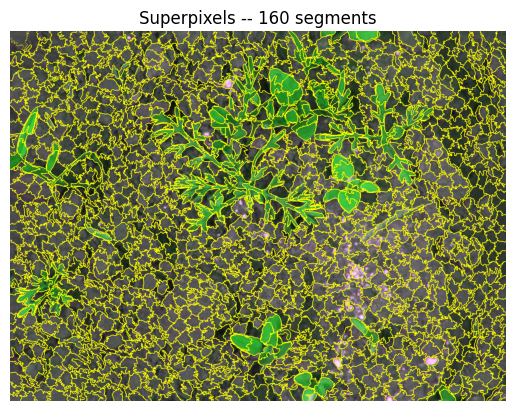

In [11]:

import cv2
from skimage.segmentation import mark_boundaries 
from PIL import Image 
import matplotlib.pyplot as plt 
fig = plt.figure() 
plt.ion()
ax = fig.add_subplot(1, 1, 1) 
ax.set_title("Superpixels -- %d segments" % (160)) 
ax.imshow(mark_boundaries(image, assignment)) 
plt.axis("off") 
plt.show()
# slic_img = mark_boundaries(image, assignment)
# x_pos, y_pos, w, h = cv2.selectROI('location', slic_img, False)
# print(x_pos, y_pos)
# print(w, h)



In [4]:
assignment.shape

(966, 1296)

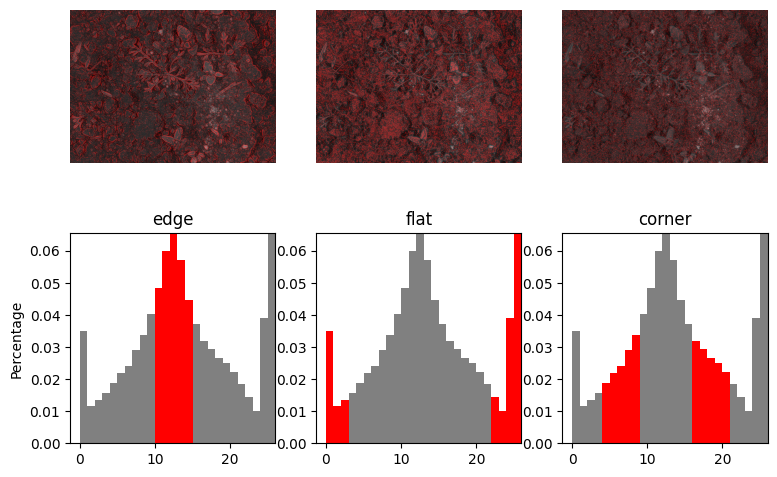

In [21]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

METHOD = 'uniform'
# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


# image = data.brick()
img = "/content/data/semi_sup_data/CWFID/num30/test/input/004_image.png"
image =np.array( Image.open(img).convert("L"))
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')


In [23]:
lbp

array([[ 7.,  8.,  9., ...,  0.,  0.,  1.],
       [ 8.,  9., 10., ...,  0.,  0.,  1.],
       [ 7.,  7., 25., ...,  0.,  1.,  4.],
       ...,
       [ 2., 25.,  0., ...,  8.,  6.,  6.],
       [ 8.,  0., 25., ..., 25.,  6.,  5.],
       [ 7., 25., 25., ...,  9.,  5.,  4.]])

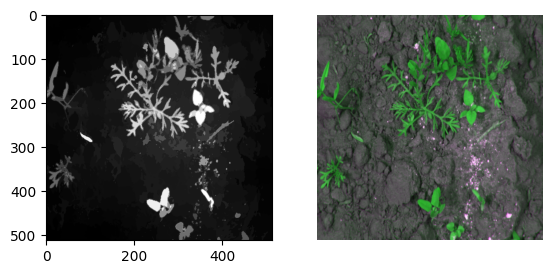

In [75]:
# https://github.dev/yhenon/pyimgsaliency/blob/master/pyimgsaliency/saliency.py
# https://github.com/lihezhang-dut/AMC_AE
# https://github.dev/yhenon/pyimgsaliency/blob/master/pyimgsaliency/saliency.py
# https://github.com/lihezhang-dut/AMC_AE
import cv2
import math
import sys
import operator
import networkx as nx
#import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance
import scipy.signal
import skimage
import skimage.io
from skimage.segmentation import slic
from fast_slic import Slic
from skimage.util import img_as_float
from scipy.optimize import minimize

import pdb

def S(x1,x2,geodesic,sigma_clr=10):
	return math.exp(-pow(geodesic[x1,x2],2)/(2*sigma_clr*sigma_clr))

def compute_saliency_cost(smoothness,w_bg,wCtr):
	n = len(w_bg)
	A = np.zeros((n,n))
	b = np.zeros((n))

	for x in range(0,n):
		A[x,x] = 2 * w_bg[x] + 2 * (wCtr[x])
		b[x] = 2 * wCtr[x]
		for y in range(0,n):
			A[x,x] += 2 * smoothness[x,y]
			A[x,y] -= 2 * smoothness[x,y]
	
	x = np.linalg.solve(A, b)

	return x

def path_length(path,G):
	dist = 0.0
	for i in range(1,len(path)):
		dist += G[path[i - 1]][path[i]]['weight']
	return dist

def make_graph(grid):
	# get unique labels
	vertices = np.unique(grid)  # segment 된 라벨들 (1, 2, 3, 4, ...)

	# map unique labels to [1,...,num_labels]
	# reverse_dict = dict(zip(vertices,np.arange(len(vertices)))) # 1을 0으로, 2를 1로, 3을 2로 .... 
 	# grid = np.array([reverse_dict[x] for x in grid.flat]).reshape(grid.shape) 
	# grid = grid - 1

	# create edges
	down = np.c_[grid[:-1, :].ravel(), grid[1:, :].ravel()] # 두개의 1차원 배열을 column으로 세로로 붙어 2차원 배열 만들기 966-1
	right = np.c_[grid[:, :-1].ravel(), grid[:, 1:].ravel()] # 위아래 근접 좌우 근접 조합을 만드는 것임 1296-1
	all_edges = np.vstack([right, down]) # 그 조합들을 합침
	all_edges = all_edges[all_edges[:, 0] != all_edges[:, 1], :] # 조합된 두개의 근접 조합의 vertice가 같지 않은 것들만 남김
	all_edges = np.sort(all_edges,axis=1) # 조합들을 오름차순으로 정리
	num_vertices = len(vertices)
	edge_hash = all_edges[:,0] + num_vertices * all_edges[:, 1] # 작은 값 + vertice 수 * 큰값으로 고유한 어떤 값으로 조합을 정의함
	# find unique connections
	edges = np.unique(edge_hash)
	# undo hashing
	edges = [[vertices[x%num_vertices],
			  vertices[x//num_vertices]] for x in edges] 
 
	return vertices, edges
	

def get_saliency_rbd(img_path, 
                     n_segments=250, 
                     sigma_clr = 10.0,
					 sigma_bndcon = 1.0,
					 sigma_spa = 0.25,
					 mu = 0.1):

	# Saliency map calculation based on:
	# Saliency Optimization from Robust Background Detection, Wangjiang Zhu, Shuang Liang, Yichen Wei and Jian Sun, IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2014

	img = skimage.io.imread(img_path)
	img = skimage.transform.resize(img, (512, 512))
	if len(img.shape) != 3: # got a grayscale image
		img = skimage.color.gray2rgb(img)

	img_lab = img_as_float(skimage.color.rgb2lab(img))

	img_rgb = img_as_float(img)

	img_gray = img_as_float(skimage.color.rgb2gray(img))
    
	# f_slic = Slic(num_components=250, compactness=10, min_size_factor=0)
	# segments_slic = f_slic.iterate(img) # Cluster Map, 0부터 시작
	segments_slic = slic(img_rgb, n_segments=n_segments, compactness=10, sigma=1, enforce_connectivity=False, start_label=0)

	num_segments = len(np.unique(segments_slic)) # 250

	nrows, ncols = segments_slic.shape # 966, 1296
	max_dist = math.sqrt(nrows*nrows + ncols*ncols) # 1616.4071269330632 -> 대각선 길이

	grid = segments_slic

	(vertices,edges) = make_graph(grid) # 0~249 array, 685개의 2개요소 리스트
	# grid = grid - 1
	gridx, gridy = np.mgrid[:grid.shape[0], :grid.shape[1]]

	centers = dict()
	colors = dict()
	distances = dict()
	boundary = dict()

	for v in vertices:
		centers[v] = [gridy[grid == v].mean(), gridx[grid == v].mean()]
		colors[v] = np.mean(img_lab[grid==v],axis=0)

		x_pix = gridx[grid == v]
		y_pix = gridy[grid == v]

		if np.any(x_pix == 0) or np.any(y_pix == 0) or np.any(x_pix == nrows - 1) or np.any(y_pix == ncols - 1):
			boundary[v] = 1
		else:
			boundary[v] = 0

	G = nx.Graph()

	#buid the graph
	for edge in edges:
		pt1 = edge[0]
		pt2 = edge[1]
		color_distance = scipy.spatial.distance.euclidean(colors[pt1],colors[pt2])
		G.add_edge(pt1, pt2, weight=color_distance )

	#add a new edge in graph if edges are both on boundary
	for v1 in vertices:
		if boundary[v1] == 1:
			for v2 in vertices:
				if boundary[v2] == 1:
					color_distance = scipy.spatial.distance.euclidean(colors[v1],colors[v2])
					G.add_edge(v1,v2,weight=color_distance)

	geodesic = np.zeros((len(vertices),len(vertices)),dtype=float)
	spatial = np.zeros((len(vertices),len(vertices)),dtype=float)
	smoothness = np.zeros((len(vertices),len(vertices)),dtype=float)
	adjacency = np.zeros((len(vertices),len(vertices)),dtype=float)

	
	all_shortest_paths_color = nx.shortest_path(G,source=None,target=None,weight='weight')

	for v1 in vertices:
		for v2 in vertices:
			if v1 == v2:
				geodesic[v1,v2] = 0
				spatial[v1,v2] = 0
				smoothness[v1,v2] = 0
			else:
				geodesic[v1,v2] = path_length(all_shortest_paths_color[v1][v2],G)
				spatial[v1,v2] = scipy.spatial.distance.euclidean(centers[v1],centers[v2]) / max_dist
				smoothness[v1,v2] = math.exp( - (geodesic[v1,v2] * geodesic[v1,v2])/(2.0*sigma_clr*sigma_clr)) + mu 

	for edge in edges:
		pt1 = edge[0]
		pt2 = edge[1]
		adjacency[pt1,pt2] = 1
		adjacency[pt2,pt1] = 1

	for v1 in vertices:
		for v2 in vertices:
			smoothness[v1,v2] = adjacency[v1,v2] * smoothness[v1,v2]

	area = dict()
	len_bnd = dict()
	bnd_con = dict()
	w_bg = dict()
	ctr = dict()
	wCtr = dict()

	for v1 in vertices:
		area[v1] = 0
		len_bnd[v1] = 0
		ctr[v1] = 0
		for v2 in vertices:
			d_app = geodesic[v1,v2]
			d_spa = spatial[v1,v2]
			w_spa = math.exp(- ((d_spa)*(d_spa))/(2.0*sigma_spa*sigma_spa))
			area_i = S(v1,v2,geodesic)
			area[v1] += area_i
			len_bnd[v1] += area_i * boundary[v2]
			ctr[v1] += d_app * w_spa
		bnd_con[v1] = len_bnd[v1] / math.sqrt(area[v1])
		w_bg[v1] = 1.0 - math.exp(- (bnd_con[v1]*bnd_con[v1])/(2*sigma_bndcon*sigma_bndcon))

	for v1 in vertices:
		wCtr[v1] = 0
		for v2 in vertices:
			d_app = geodesic[v1,v2]
			d_spa = spatial[v1,v2]
			w_spa = math.exp(- (d_spa*d_spa)/(2.0*sigma_spa*sigma_spa))
			wCtr[v1] += d_app * w_spa *  w_bg[v2]

	# normalise value for wCtr

	min_value = min(wCtr.values())
	max_value = max(wCtr.values())

	minVal = [key for key, value in wCtr.items() if value == min_value]
	maxVal = [key for key, value in wCtr.items() if value == max_value]

	for v in vertices:
		wCtr[v] = (wCtr[v] - min_value)/(max_value - min_value)

	img_disp1 = img_gray.copy()
	img_disp2 = img_gray.copy()

	x = compute_saliency_cost(smoothness,w_bg,wCtr)

	for v in vertices:
		img_disp1[grid == v] = x[v]

	img_disp2 = img_disp1.copy()
	sal = np.zeros((img_disp1.shape[0],img_disp1.shape[1],3))

	sal = img_disp2
	sal_max = np.max(sal)
	sal_min = np.min(sal)
	sal = 255 * ((sal - sal_min) / (sal_max - sal_min))

	return sal

def get_saliency_ft(img_path):

	# Saliency map calculation based on:

	img = skimage.io.imread(img_path)

	img_rgb = img_as_float(img)

	img_lab = skimage.color.rgb2lab(img_rgb) 

	mean_val = np.mean(img_rgb,axis=(0,1))

	kernel_h = (1.0/16.0) * np.array([[1,4,6,4,1]])
	kernel_w = kernel_h.transpose()

	blurred_l = scipy.signal.convolve2d(img_lab[:,:,0],kernel_h,mode='same')
	blurred_a = scipy.signal.convolve2d(img_lab[:,:,1],kernel_h,mode='same')
	blurred_b = scipy.signal.convolve2d(img_lab[:,:,2],kernel_h,mode='same')

	blurred_l = scipy.signal.convolve2d(blurred_l,kernel_w,mode='same')
	blurred_a = scipy.signal.convolve2d(blurred_a,kernel_w,mode='same')
	blurred_b = scipy.signal.convolve2d(blurred_b,kernel_w,mode='same')

	im_blurred = np.dstack([blurred_l,blurred_a,blurred_b])

	sal = np.linalg.norm(mean_val - im_blurred,axis = 2)
	sal_max = np.max(sal)
	sal_min = np.min(sal)
	sal = 255 * ((sal - sal_min) / (sal_max - sal_min))
	return sal


img = "/content/data/semi_sup_data/CWFID/num30/test/input/004_image.png"

rbd = get_saliency_rbd(img, 
                     n_segments=250, 
                     sigma_clr = 5.0,
					 sigma_bndcon =0.4,
					 sigma_spa = 8,
					 mu = 0.1).astype('uint8')
# rbd = get_saliency_rbd(img).astype('uint8')
fig = plt.figure() 
ax = fig.add_subplot(1, 2, 1) 
ax.imshow(rbd, cmap='gray') 
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(Image.open(img).resize((512,512)))
plt.axis("off") 
plt.show()

In [33]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
print(rbd)


[[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   

In [5]:
from skimage.segmentation import slic
from fast_slic import Slic
import skimage
img_path = "/content/data/semi_sup_data/CWFID/num30/test/input/001_image.png"
img = skimage.io.imread(img_path)

if len(img.shape) != 3: # got a grayscale image
    img = skimage.color.gray2rgb(img)
img_rgb = img_as_float(img)
slic_f = Slic(num_components=250, compactness=10, min_size_factor=0)



In [6]:
fast_slic = slic_f.iterate(img) # Cluster Map

In [10]:
sk_slic = slic(img_rgb, n_segments=250, compactness=10, sigma=1, enforce_connectivity=False, start_label=0)

In [11]:
fast_slic

array([[  0,   0,   0, ...,  16,  16,  16],
       [  0,   0,   0, ...,  16,  16,  16],
       [  0,   0,   0, ...,  16,  16,  16],
       ...,
       [247, 247, 247, ..., 238, 238, 238],
       [247, 247, 247, ..., 238, 238, 238],
       [247, 247, 247, ..., 238, 238, 238]], dtype=int16)

In [12]:
sk_slic

array([[  0,   0,   0, ...,  17,  17,  17],
       [  0,   0,   0, ...,  17,  17,  17],
       [  0,   0,   0, ...,  17,  17,  17],
       ...,
       [234, 234, 234, ..., 251, 251, 251],
       [234, 234, 234, ..., 233, 233, 233],
       [234, 234, 234, ..., 233, 233, 233]])